In [1]:
#Importing necessary files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [2]:
#Setting up tensorflow environment
tf.random.set_seed(42)

In [3]:
#Loading CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

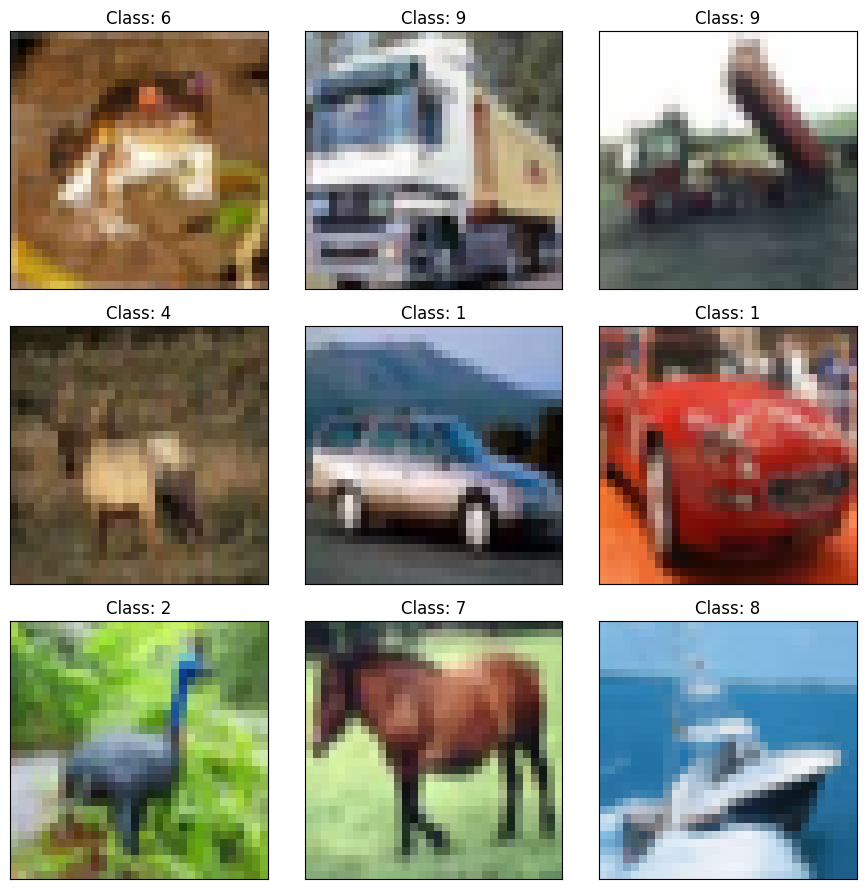

In [4]:
#Exploring dataset
f, ax = plt.subplots(3,3,figsize=(9,9))
ax = ax.flatten()

for i in range(9):
    ax[i].imshow(x_train[i,:,:])
    ax[i].set_title(f'Class: {y_train[i][0]}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

In [5]:
#Normalizing pixel values
x_train, x_test = x_train/255.0 , x_test/255.0

In [6]:
#Loading pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False,
                                         input_shape=(32, 32, 3))

In [7]:
#Freezing all the layers for making the model not trainable
base_model.trainable = False

In [8]:
#Looking at the base_model parameters
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

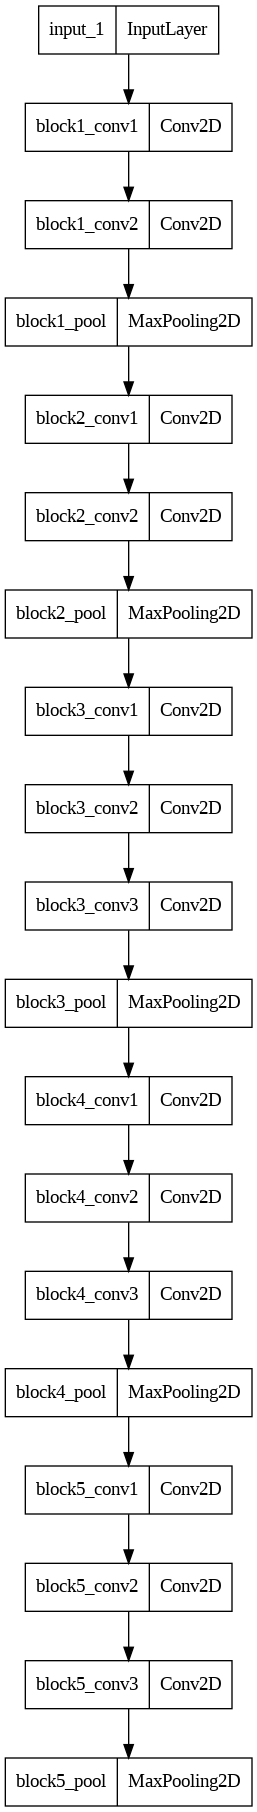

In [9]:
#Plotting the base_model
plot_model(base_model)

In [73]:
#Adding layers on top to finish the transfer learning model
inputs = tf.keras.Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
#Looking at the transfer learning model parameters
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
Total params: 14719818 (56.15 MB)
Trainable params: 5130 (20.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


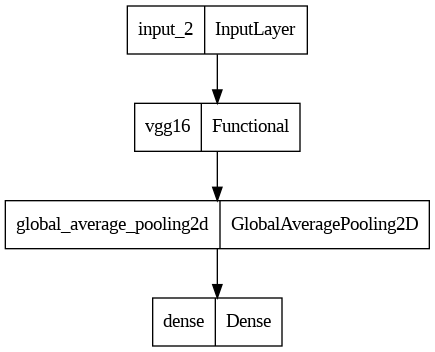

In [12]:
#Plotting transfer learning model
plot_model(model)

In [13]:
#Compiling the model with non trainable layers
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
#Creating a chectpoint to store trainimg weights with good accuracy
checkpoint_filepath = '/content/save_weights'

saved_weights = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max', verbose=1)

#Creating Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
#Training the non-trainable transfer learning model
history=model.fit(x_train, y_train, epochs=20, batch_size=512,
                  validation_data=(x_test, y_test),
                  callbacks=[saved_weights, lr_scheduler])

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 2.3614 - accuracy: 0.1212
Epoch 1: val_accuracy improved from -inf to 0.15550, saving model to /content/save_weights
98/98 [==============================] - 20s 139ms/step - loss: 2.3614 - accuracy: 0.1212 - val_loss: 2.2638 - val_accuracy: 0.1555 - lr: 1.0000e-04
Epoch 2/20
97/98 [============================>.] - ETA: 0s - loss: 2.2006 - accuracy: 0.1895
Epoch 2: val_accuracy improved from 0.15550 to 0.23170, saving model to /content/save_weights
98/98 [==============================] - 8s 79ms/step - loss: 2.2005 - accuracy: 0.1897 - val_loss: 2.1451 - val_accuracy: 0.2317 - lr: 1.0000e-04
Epoch 3/20
97/98 [============================>.] - ETA: 0s - loss: 2.0960 - accuracy: 0.2583
Epoch 3: val_accuracy improved from 0.23170 to 0.28600, saving model to /content/save_weights
98/98 [==============================] - 8s 84ms/step - loss: 2.0958 - accuracy: 0.2584 - val_loss: 2.0533 - val_accuracy: 0.2860 - lr: 1.0000e

In [16]:
#Unfreezing all layers in the base_model
base_model.trainable = True

#Compiling the trainable model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
#Training the transfer learning model with all trainable layers
history1=model.fit(x_train, y_train, epochs=20, batch_size=512, validation_data=(x_test, y_test), callbacks=[saved_weights, lr_scheduler])

Epoch 1/20
98/98 [==============================] - ETA: 0s - loss: 1.0421 - accuracy: 0.6376
Epoch 1: val_accuracy improved from 0.47810 to 0.75960, saving model to /content/save_weights
98/98 [==============================] - 43s 279ms/step - loss: 1.0421 - accuracy: 0.6376 - val_loss: 0.6890 - val_accuracy: 0.7596 - lr: 1.0000e-04
Epoch 2/20
98/98 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.7924
Epoch 2: val_accuracy improved from 0.75960 to 0.79560, saving model to /content/save_weights
98/98 [==============================] - 21s 211ms/step - loss: 0.5916 - accuracy: 0.7924 - val_loss: 0.5959 - val_accuracy: 0.7956 - lr: 1.0000e-04
Epoch 3/20
98/98 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8398
Epoch 3: val_accuracy improved from 0.79560 to 0.80350, saving model to /content/save_weights
98/98 [==============================] - 20s 204ms/step - loss: 0.4551 - accuracy: 0.8398 - val_loss: 0.5840 - val_accuracy: 0.8035 - lr: 

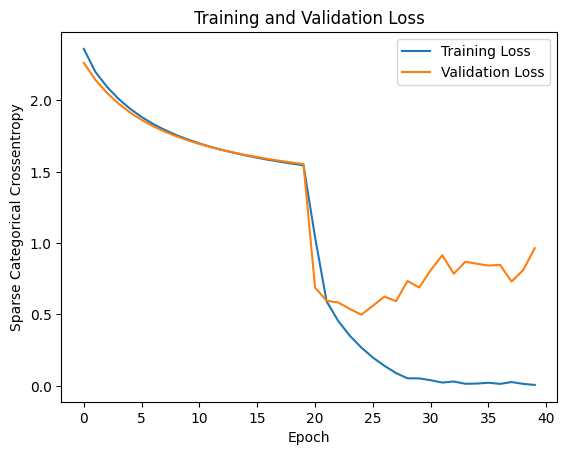

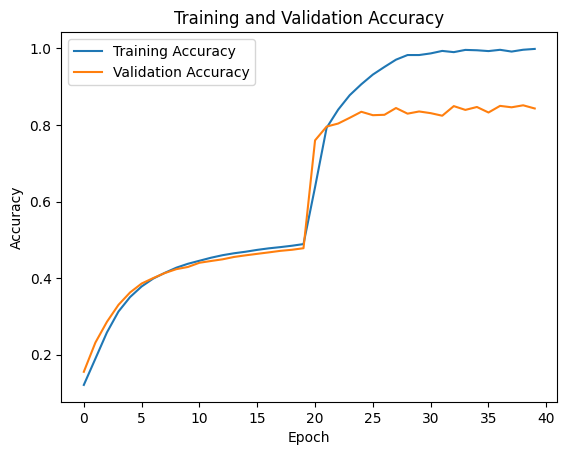

In [18]:
# Extract training history
training_loss, training_accuracy = history.history['loss']+history1.history[
    'loss'], history.history['accuracy']+history1.history['accuracy']
validation_loss, validation_accuracy = history.history[
    'val_loss']+history1.history['val_loss'], history.history[
        'val_accuracy']+history1.history['val_accuracy']

# Plot training and validation losses
plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy')
plt.legend()
plt.show()

print('\n')

# Plot training and validation accuracy
plt.figure()
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
#Loading model weights with max accuracy
model.load_weights('/content/save_weights')

#True Class labels
true_labels=y_test.reshape(1,10000)[0]

#Predicted Class labels
predictions = model.predict(x_test)
predictions=np.argmax(predictions, axis = 1)

#Evaluating the model performance
loss, accuracy = model.evaluate(x_test, y_test)
print(f'The Transfer Learning model accuracy is {np.round(accuracy,2)}')

313/313 [==============================] - 2s 8ms/step - loss: 0.8108 - accuracy: 0.8511
The Transfer Learning model accuracy is 0.85


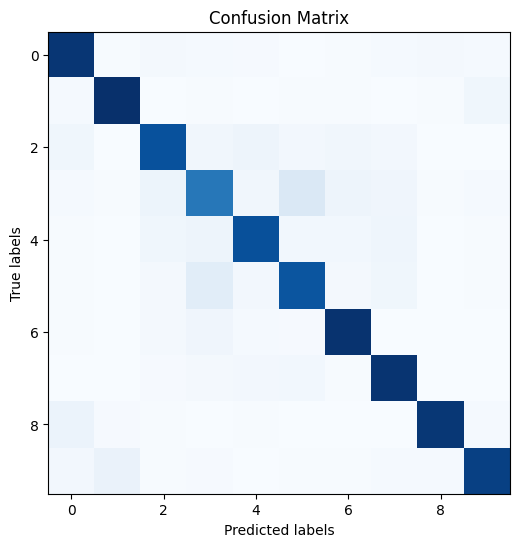

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1000
           1       0.91      0.93      0.92      1000
           2       0.83      0.81      0.82      1000
           3       0.72      0.67      0.69      1000
           4       0.85      0.81      0.83      1000
           5       0.78      0.79      0.78      1000
           6       0.87      0.91      0.89      1000
           7       0.84      0.91      0.87      1000
           8       0.95      0.90      0.92      1000
           9       0.91      0.87      0.89      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [28]:
from sklearn.metrics import confusion_matrix, classification_report

#Bulding Confusion Matrix
confusion_mat = confusion_matrix(true_labels, predictions)

#Plot Confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report = classification_report(true_labels, predictions)
print(classification_report)

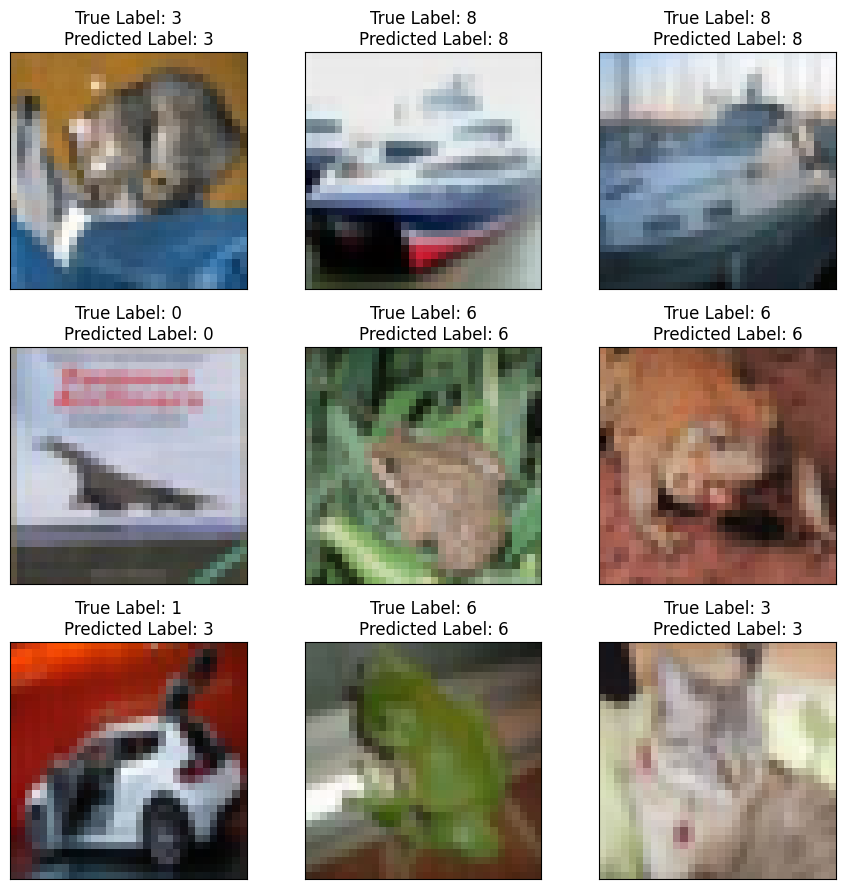

In [72]:
#Exploring test dataset and predictions
f, ax = plt.subplots(3,3,figsize=(9,9))
ax = ax.flatten()

for i in range(9):
    ax[i].imshow(x_test[i,:,:])
    ax[i].set_title(f'''True Label: {true_labels[i]}
    Predicted Label: {predictions[i]}''')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

In [74]:
 #Building new image classification model from scratch
model_scratch = tf.keras.models.Sequential()
model_scratch.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu',
                                         input_shape=(32, 32, 3)))
model_scratch.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu'))
model_scratch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
model_scratch.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu'))
model_scratch.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu'))
model_scratch.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))
model_scratch.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu'))
model_scratch.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1),
                                         padding='same',activation='relu'))
model_scratch.add(tf.keras.layers.Flatten())
model_scratch.add(tf.keras.layers.Dense(128, activation='relu'))
model_scratch.add(tf.keras.layers.Dense(10, activation='softmax'))

In [75]:
#Checking my scratch model parameters
model_scratch.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                 

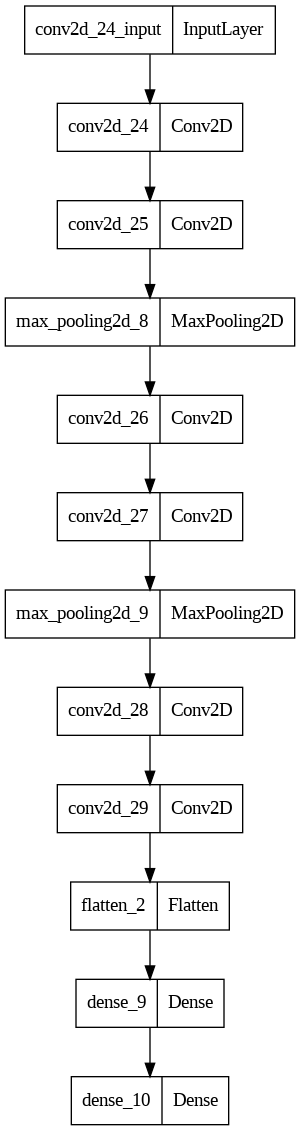

In [76]:
#Plotting my scratch model
plot_model(model_scratch)

In [77]:
#Compiling my scratch model
model_scratch.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [78]:
#Creating a checkpoint for saving my scratch model weights
checkpoint_filepath = '/content/save_weights_scratch'

save_weights_scratch = tf.keras.callbacks.ModelCheckpoint(
                                                   filepath=checkpoint_filepath,
                                                   save_best_only=True,
                                                   monitor='val_accuracy',
                                                   mode='max', verbose=1)

In [79]:
#Training my scratch model
history_X=model_scratch.fit(x_train, y_train, epochs=50, batch_size=512,
                            validation_data=(x_test, y_test),
                            callbacks=[save_weights_scratch, lr_scheduler])

Epoch 1/50
98/98 [==============================] - ETA: 0s - loss: 1.9955 - accuracy: 0.2758
Epoch 1: val_accuracy improved from -inf to 0.38940, saving model to /content/save_weights_scratch
98/98 [==============================] - 10s 70ms/step - loss: 1.9955 - accuracy: 0.2758 - val_loss: 1.7105 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 2/50
97/98 [============================>.] - ETA: 0s - loss: 1.6050 - accuracy: 0.4229
Epoch 2: val_accuracy improved from 0.38940 to 0.44130, saving model to /content/save_weights_scratch
98/98 [==============================] - 5s 56ms/step - loss: 1.6047 - accuracy: 0.4229 - val_loss: 1.5344 - val_accuracy: 0.4413 - lr: 1.0000e-04
Epoch 3/50
97/98 [============================>.] - ETA: 0s - loss: 1.4743 - accuracy: 0.4688
Epoch 3: val_accuracy improved from 0.44130 to 0.49560, saving model to /content/save_weights_scratch
98/98 [==============================] - 5s 56ms/step - loss: 1.4740 - accuracy: 0.4688 - val_loss: 1.4094 - val_accurac

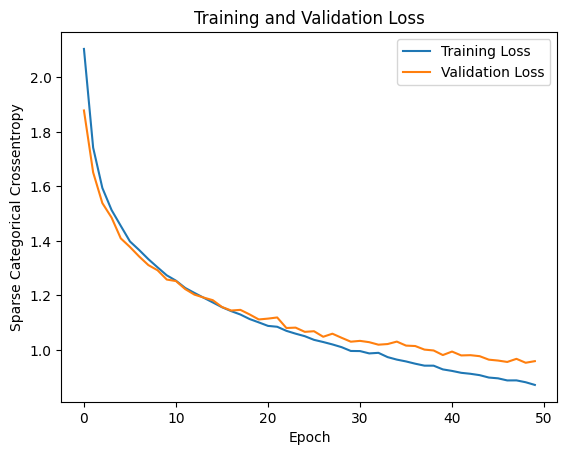

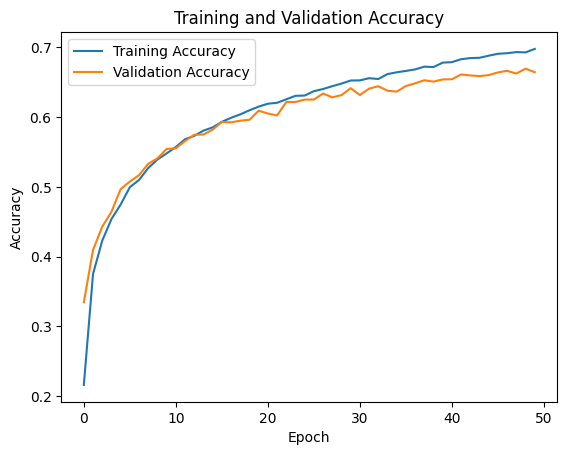

In [54]:
# Extract training history
training_loss, training_accuracy = history_X.history[
    'loss'], history_X.history['accuracy']
validation_loss, validation_accuracy = history_X.history[
    'val_loss'], history_X.history['val_accuracy']

# Plot training and validation losses
plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy')
plt.legend()
plt.show()

print('\n')

# Plot training and validation accuracy
plt.figure()
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [65]:
#Loading model weights with max accuracy
model_scratch.load_weights('/content/save_weights_scratch')

#Predicted Class labels
predictions_scratch = model_scratch.predict(x_test)
predictions_scratch=np.argmax(predictions_scratch, axis=1)

#Evaluating the model performance
loss, accuracy = model_scratch.evaluate(x_test, y_test)
print(f'The Scratch model accuracy is {accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 0.9528 - accuracy: 0.6693
The Scratch model accuracy is 0.6693000197410583


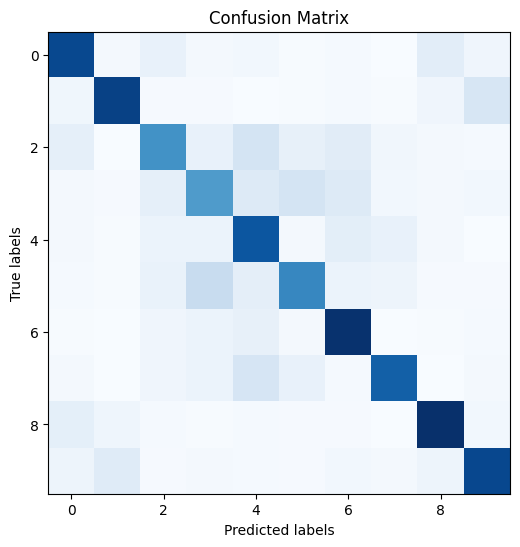

              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1000
           1       0.80      0.75      0.77      1000
           2       0.59      0.50      0.54      1000
           3       0.51      0.47      0.49      1000
           4       0.54      0.69      0.61      1000
           5       0.62      0.54      0.58      1000
           6       0.66      0.80      0.73      1000
           7       0.78      0.66      0.71      1000
           8       0.77      0.81      0.79      1000
           9       0.73      0.73      0.73      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



In [67]:
from sklearn.metrics import confusion_matrix, classification_report

#Bulding Confusion Matrix
confusion_mat = confusion_matrix(true_labels, predictions_scratch)

#Plot Confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report
classification_report = classification_report(true_labels, predictions_scratch)
print(classification_report)

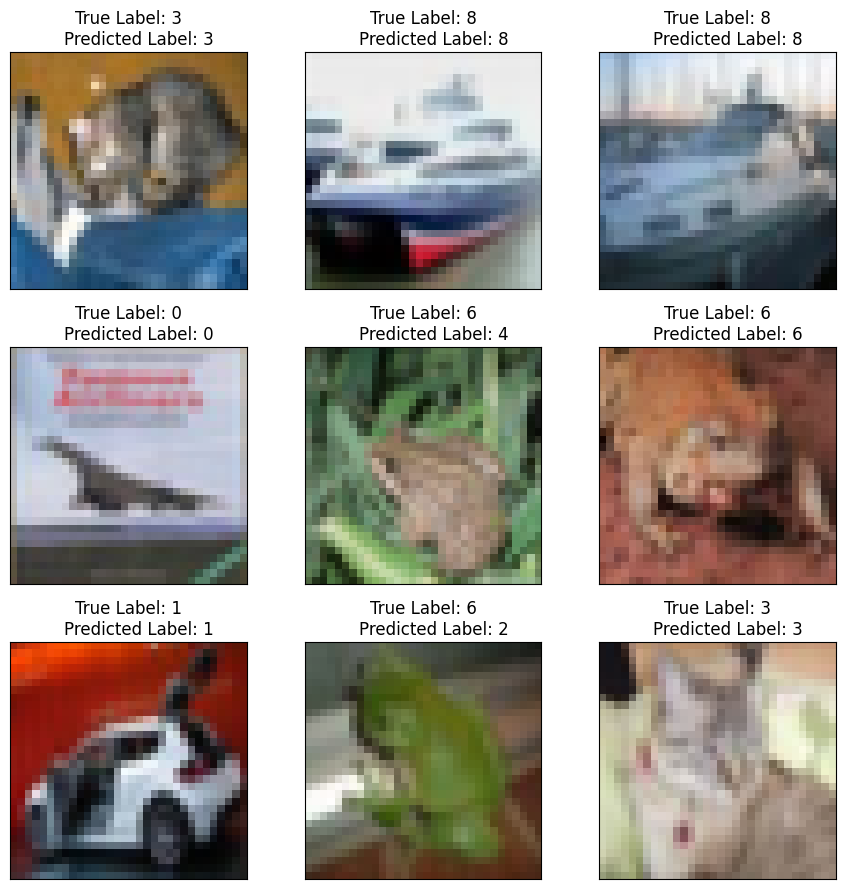

In [71]:
#Exploring test dataset and predictions
f, ax = plt.subplots(3,3,figsize=(9,9))
ax = ax.flatten()

for i in range(9):
    ax[i].imshow(x_test[i,:,:])
    ax[i].set_title(f'''True Label: {true_labels[i]}
    Predicted Label: {predictions_scratch[i]}''')
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()